In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_lalonde = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link_lalonde.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold


def preprocess_data(df, dataset='hillstrom', verbose=True):
    # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
    #   as the target variable of interest and the selected treatment is 
    #   the e-mail campaign for women’s merchandise [1]
    # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
    #    J Market Anal. 2014;2:218–238
    dataset = dataset.lower()
    if dataset in ('hillstrom', 'email'):
        columns = df.columns
        for col in columns:
            if df[col].dtype != object:
                continue
            df = pd.concat(
                    [df, pd.get_dummies(df[col], 
                                        prefix=col, 
                                        drop_first=False)],
                    axis=1)
            df.drop([col], axis=1, inplace=True)

        df.columns = [col.replace('-', '').replace(' ', '_').lower()
                      for col in df.columns]
        df = df[df.segment_mens_email == 0]
        df.index = range(len(df))
        df.drop(['segment_mens_email', 
                 'segment_no_email', 
                 'conversion', 
                 'spend'], axis=1, inplace=True)

        y_name = 'visit'
        t_name = 'segment_womens_email'
    elif dataset in ['criteo', 'ad']:
        raise NotImplementedError
    elif dataset in ['lalonde', 'job']:
        raise NotImplementedError
    else:
        raise NotImplementedError
    
    df['Y'] = df[y_name]
    df.drop([y_name], axis=1, inplace=True)
    df['T'] = df[t_name]
    df.drop([t_name], axis=1, inplace=True)
    
    return df

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def performance(pr_y1_t1, pr_y1_t0, y, t, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_t1: the series (list) of the customer's expected return
        pr_y1_t0: the expected return when a customer is not treated
        y: the observed return of customers
        t: whther each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_t1': the number of treated responders
                'n_y1_t0': the number of not treated responders
                'r_y1_t1': the average return of treated customers
                'r_y1_t0': the average return of not treated customers
                'n_t1': the number of treated customers
                'n_t0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """
  
    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")
  
    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if t.isnull().values.any():
        raise Exception("uplift: NA not permitted in t")
   
    ### check valid values for y and t
    # if set(y) != {0, 1}:
    #     raise Exception("uplift: y must be either 0 or 1")
    if set(t) != {0, 1}:
        raise Exception("uplift: t must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(t)):
        raise Exception("uplift: arguments pr_y1_t1, pr_y1_t0, y and t must all have the same length")

    ### define dif_pred
    dif_pred = pr_y1_t1 - pr_y1_t0
  
    ### Make index same
    y.index = dif_pred.index
    t.index = dif_pred.index
    
    mm = pd.DataFrame({
        'dif_pred': dif_pred,
        'y': y,
        't': t,
        'dif_pred_r': dif_pred.rank(ascending=False, method='first')
    })

    mm_groupby = mm.groupby(pd.qcut(mm['dif_pred_r'], groups, labels=range(1, groups+1), duplicates='drop'))
  
    n_y1_t1 = mm_groupby.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = mm_groupby.apply(lambda r: r[r['t'] == 0]['y'].sum())
    n_t1 = mm_groupby['t'].sum()
    n_t0 = mm_groupby['t'].count() - n_t1
  
    df = pd.DataFrame({
        'n_t1': n_t1,
        'n_t0': n_t0,
        'n_y1_t1': n_y1_t1,
        'n_y1_t0': n_y1_t0,
        'r_y1_t1': n_y1_t1 / n_t1,
        'r_y1_t0': n_y1_t0 / n_t0,
    })
    fillna_columns = ['n_y1_t1', 'n_y1_t0', 'n_t1', 'n_t0']
    df[fillna_columns] = df[fillna_columns].fillna(0)
    df.index.name = 'groups'

    df['uplift'] = df['r_y1_t1'] - df['r_y1_t0']
    df['uplift'] = round(df['uplift'], 6)

    return df


def qini(perf, plotit=True):
    nrow = len(perf)

    # Calculating the incremental gains. 
    # - First, the cumulitative sum of the treated and the control groups are
    #  calculated with respect to the total population in each group at the
    #  specified decile
    # - Afterwards we calculate the percentage of the total amount of people
    #  (both treatment and control) are present in each decile
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res


In [0]:
import itertools
import numpy as np

def parameter_tuning(fit_mdl, pred_mdl, data, search_space):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
    
    max_q = -float('inf')
    best_mdl = None

    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)
    
    best_params = None
    for i in range(n_iter):
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        mdl = fit_mdl(x_train, y_train, t_train, **params)
        pred = pred_mdl(mdl, newdata=x_test, y=y_test, ct=t_test)
        # print('    {}'.format(params))
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        except Exception as e:
            print(e)
            continue
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params


def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None):
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']

    variables = data['x_train'].columns

    max_q = -float('inf')
    drop_var = None
    best_mdl = None
    for var in variables:
        if var in drop_variables:
            continue
        x = x_train.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        mdl = fit_mdl(x, y_train, t_train, **params)
        x = x_test.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        pred = pred_mdl(mdl, newdata=x, y=y_test, ct=t_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl
    
    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)

    left_vars = [var for var in variables if (var not in drop_variables)]
    
    if len(variables) == len(drop_variables) + 1:
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values)



In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def tma(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    
    treat_rows = (t == 1)
    control_rows = (t == 0)
    model_treat = method(**kwargs).fit(x[treat_rows], y[treat_rows])
    model_control = method(**kwargs).fit(x[control_rows], y[control_rows])
    
    res = {
        'model_treat': model_treat,
        'model_control': model_control,
    }
    return res


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
    """
   
    if isinstance(obj['model_treat'], LinearRegression):
        pred_treat = obj['model_treat'].predict(newdata)
    else:
        pred_treat = obj['model_treat'].predict_proba(newdata)[:, 1]

    if isinstance(obj['model_control'], LinearRegression):
        pred_control = obj['model_control'].predict(newdata)
    else:
        pred_control = obj['model_control'].predict_proba(newdata)[:, 1]
    
    # pred_treat = obj['model_treat'].predict(newdata)
    # pred_control = obj['model_control'].predict(newdata)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df



In [0]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None


def t_assign(ty):
    if ty in ("TR", "TN"):
        return 1
    elif ty in ("CR", "CN"):
        return 0
    else:
        return None


def y_assign(ty):
    if ty in ("TR", "CR"):
        return 1
    elif ty in ("TN", "CN"):
        return 0
    else:
        return None

search_space = {
    'method': [LogisticRegression],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['none', 'l2'],
    'tol': [1e-2, 1e-3, 1e-4],
    'C': [1e6, 1e3, 1, 1e-3, 1e-6],
}

def main():
    ### Load data ###
    df = pd.read_csv('Hillstrom.csv')
    dataset = 'hillstrom'
    df = preprocess_data(df)
    Y = df['Y']
    T = df['T']
    X = df.drop(['Y', 'T'], axis=1)
    ty = pd.DataFrame({'Y': Y, 'T': T})\
             .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)
    if dataset == 'hillstrom':
        fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
    elif dataset == 'lalonde':
        fold_gen = KFold(n_splits=5, shuffle=True, random_state=1234).split(X)
    else:
        pass


    ### Cross validation ###
    qini_list = []
    for idx, (train_index, test_index) in enumerate(fold_gen):
        X_train = X.reindex(train_index)
        X_test = X.reindex(test_index)
        Y_train = Y.reindex(train_index)
        Y_test = Y.reindex(test_index)
        T_train = T.reindex(train_index)
        T_test = T.reindex(test_index)

#         df = X_train.copy()
#         df['Y'] = Y_train
#         df['T'] = T_train
#         stratify = T_train
#         if dataset == 'hillstrom':
#             stratify = df[['Y', 'T']]
#         tuning_df, validate_df = train_test_split(
#             df, test_size=0.33, random_state=1234, stratify=stratify)

#         X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
#         Y_tuning = tuning_df['Y']
#         T_tuning = tuning_df['T']

#         X_validate = validate_df.drop(['Y', 'T'], axis=1)
#         Y_validate = validate_df['Y']
#         T_validate = validate_df['T']
        
#         data_dict = {
#             "x_train": X_tuning,
#             "y_train": Y_tuning,
#             "t_train": T_tuning,
#             "x_test": X_validate,
#             "y_test": Y_validate,
#             "t_test": T_validate,
#         }
        
#         model_method = search_space.get('method', None)
#         params = {
#             'method': None if model_method is None else model_method[0],
#         }
#         if params['method'] == LogisticRegression:
#             solver = search_space.get('solver', None)
#             params['solver'] = None if solver is None else solver[0]

#         _, drop_vars, qini_values = wrapper(
#                 tma, predict_tma, data_dict, params=params)
#         best_qini = max(qini_values)
#         best_idx = qini_values.index(best_qini)
#         best_drop_vars = drop_vars[:best_idx]

#         X_tuning.drop(best_drop_vars, axis=1, inplace=True)
#         X_validate.drop(best_drop_vars, axis=1, inplace=True)
#         X_train.drop(best_drop_vars, axis=1, inplace=True)
#         X_test.drop(best_drop_vars, axis=1, inplace=True)

#         _, best_params = parameter_tuning(tma, predict_tma, data_dict, 
#                                           search_space=search_space)
        best_params = {}
        mdl = uplift_tree(X_train, Y_train, T_train, **best_params)
        pred = predict_tree(mdl, X_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
        q = qini(perf)
        qini_list.append(q['qini'])
    print('Qini values: ', qini_list)
    print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))


In [0]:
import sys
import numpy as np
import random
import math

import warnings
warnings.filterwarnings("ignore")

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None, None


def info_gain(df, attribute, predict_attr, treatment_attr):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    
    CHANGE:
        Information gain is chagned "\Delta \Delta P" which means the
        difference between the uplifts of the treatment and control group
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (information gain)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr],
        'T': df[treatment_attr]
    })
    tmp.sort_values(['thres'], inplace=True)

    tmp['n_t1_L'] = (tmp['T']).cumsum()
    tmp['n_t0_L'] = (tmp['T'] == 0).cumsum()
    tmp['n_t1_R'] = sum(tmp['T']) - (tmp['T']).cumsum()
    tmp['n_t0_R'] = sum(tmp['T'] == 0) - (tmp['T'] == 0).cumsum()
    tmp['n_y_t1_L'] = (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_L'] = ((tmp['T'] == 0) & tmp['Y']).cumsum()
    tmp['n_y_t1_R'] = sum(tmp['T'] & tmp['Y']) - (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_R'] = sum((tmp['T'] == 0) & tmp['Y']) - ((tmp['T'] == 0) & tmp['Y']).cumsum()
    
    tmp['info_gain'] = ((tmp['n_y_t1_L']/tmp['n_t1_L']) - (tmp['n_y_t0_L']/tmp['n_t0_L'])) \
                     - ((tmp['n_y_t1_R']/tmp['n_t1_R']) - (tmp['n_y_t0_R']/tmp['n_t0_R']))
    
    
    
    # We will select one rows per one distinct candidate
    tmp['dups'] = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (tmp['dups'] == False)
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None

    tmp = tmp[tmp['thres_ok']]
    
    return tmp[['thres', 'info_gain']]
    


def num_class(df, predict_attr, treatment_attr):
    """
    Returns the number of Responders and Non-responders in Treatment and Control group
    """
    tr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 1)]  # Responders in Treatment group
    tn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 1)]  # Non-responders in Treatment group
    cr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 0)]  # Responders in Control group
    cn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 0)]  # Non-responders in Control group
    return tr.shape[0], tn.shape[0], cr.shape[0], cn.shape[0]


def choose_attr(df, attributes, predict_attr, treatment_attr):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = 0
    best_attr = None
    threshold = None
    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ig = info_gain(df, attr, predict_attr, treatment_attr)
        if df_ig is None:
            continue

        # Get the possible indices of maximum info gain
        ig = max(df_ig['info_gain'])
        idx_ig = df_ig.index[df_ig['info_gain']==ig]
        # Break ties randomly
        idx_ig = random.choice(idx_ig)
        # Get information gain & threshold of that
        thres = df_ig['thres'][idx_ig]

        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres
    return best_attr, threshold



def build_tree(df, cols, predict_attr='Y', treatment_attr='T'):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    # Get the number of positive and negative examples in the training data
    total_num = df.shape[0]
    tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
    # Whether we have to split this node
    split_cond = tr + tn > 2000 and cr + cn > 2000
    
    best_attr, threshold = None, None
    if split_cond:
        # Determine attribute and its threshold value with the highest
        # information gain
        best_attr, threshold = choose_attr(df, cols, predict_attr, treatment_attr)
    
    if best_attr is None:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        leaf.predict = (tr / (tr + tn), cr / (cr + cn))
        return leaf
    else:
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        sub1_tr, sub1_tn, sub1_cr, sub1_cn = num_class(sub_1, predict_attr, treatment_attr)
        sub2_tr, sub2_tn, sub2_cr, sub2_cn = num_class(sub_2, predict_attr, treatment_attr)
        if sub1_tr + sub1_tn < 1 or sub1_cr + sub1_cn < 1 \
                or sub2_tr + sub2_tn < 1 or sub2_cr + sub2_cn < 1:
            # Create a leaf node indicating it's prediction
            leaf = Node(None,None)
            leaf.leaf = True
            leaf.predict = (tr / (tr + tn), cr / (cr + cn))
            return leaf
        tree = Node(best_attr, threshold)
        # Recursively build left and right subtree
        tree.left = build_tree(sub_1, cols, predict_attr, treatment_attr)
        tree.right = build_tree(sub_2, cols, predict_attr, treatment_attr)
        return tree


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict
    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)


def test_predictions(root, df):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    pred_treat = []
    pred_control = []
    for index,row in df.iterrows():
        return_treated, return_control = predict(root, row)
        pred_treat.append(return_treated)
        pred_control.append(return_control)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df




In [0]:
def uplift_tree(x, y, t, **kwargs):
    df = x.copy()
    df['Y'] = y
    df['T'] = t
    
    root = build_tree(df, x.columns, predict_attr='Y', treatment_attr='T')
    
    return root


predict_tree = test_predictions


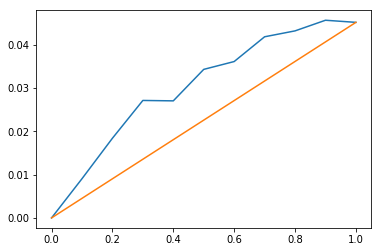

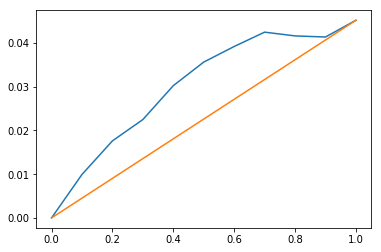

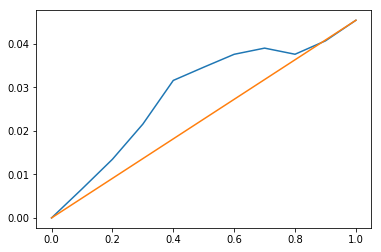

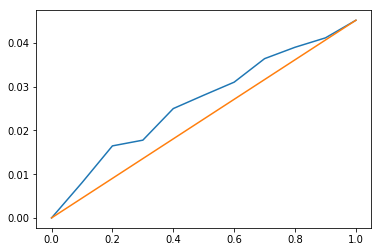

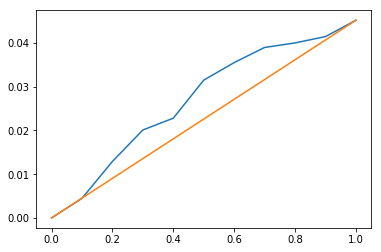

Qini values:  [0.007950409759900613, 0.007713578115910731, 0.0058385919807579095, 0.003962101123446256, 0.004437389013958088]
    mean: 0.005980413998794719, std: 0.001634586651545963


In [19]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
df = preprocess_data(df)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)


### Cross validation ###
qini_list = []
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    mdl = uplift_tree(X_train, Y_train, T_train)
    pred = predict_tree(mdl, X_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    qini_list.append(q['qini'])
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
